# Continuous Control using Proximal Policy Optimization (PPO)

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.distributions import MultivariateNormal

import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# Set the Torch random seed and compute device
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to load and print information about the environment.

In [4]:
# Load the environment
# NOTE: You should change your `env_file` variable below as needed
env = UnityEnvironment(file_name="/home/sebastian/udacity_drl/drlnd-control-project/Reacher_Linux/Reacher.x86_64")

# Get the default brain for the environment
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# Number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# Size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# Examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### Define a Policy Model

The policy below is the neural network function approximator that takes as input the state of an agent
and outputs the action (mean, standard deviation, action sample, and action log probabilities).

The parameters for this model will be trained by the PPO algorithm.

In [6]:
class PolicyModel(nn.Module):
    """
    Defines a neural network to execute the policy
    """
    
    def __init__(self, num_states=33, num_actions=4, init_std=1.0, layer_dims=[128, 64, 32]):
        """
        Initialize the policy network structure
        
        """
        super(PolicyModel, self).__init__()
        self.fc1 = nn.Linear(num_states, layer_dims[0])
        self.fc2 = nn.Linear(layer_dims[0], layer_dims[1])
        self.fc3 = nn.Linear(layer_dims[1], layer_dims[2])
        self.fc4 = nn.Linear(layer_dims[2], num_actions)
        self.act_var = nn.Parameter(init_std*torch.ones(1, action_size))        
        
    def forward(self, states, actions=None):
        """ 
        Forward pass through the Q-Network, which accepts a state (array_like)
        and returns an action (clipped between -1 and +1 with a tanh output activation).
        """
        
        x = F.relu(self.fc1(states))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        means = F.tanh(self.fc4(x))

        # If no action is passed in, sample one and compute log probability.
        # Else, directly find log probability from the given action
        n = Normal(means, self.act_var)
        if actions is None:
            actions = n.sample()
        stds = self.act_var
        logprobs = n.log_prob(actions)
        return (means, stds, actions, logprobs)
        

# Test creating a policy model
policy = PolicyModel().to(device)
print(policy)

PolicyModel(
  (fc1): Linear(in_features=33, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
)


### Trajectory Collection Function

In [8]:
def collect_trajectories(env, policy):
    """
    Utility function to step through all the agents in the environment using the
    specified policy and collect information for a complete episode.
    """

    # Initialize lists and the environment
    state_list = []
    reward_list = []
    logprob_list = []
    action_list = []
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations

    # Evaluate the policy on the environment until the episode is complete
    done = False
    while not done:

        # Get the next action from the agent
        state_tensor = torch.tensor(states, dtype=torch.float, device=device)
        (old_means, old_stds, actions, logprobs) = policy.forward(state_tensor)

        # Step the environment and unpack the information
        acts_for_env = actions.detach().cpu().numpy()
        env_info = env.step(acts_for_env)[brain_name]      # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        
        # Append the results to a list for the whole trajectory
        state_list.append(states)
        reward_list.append(rewards)
        logprob_list.append(logprobs)
        action_list.append(actions)

        # Exit the loop if the episode is finished
        if np.any(dones):
            done = True
        states = next_states

    # Return the trajectory lists
    return logprob_list, state_list, action_list, reward_list

### PPO Agent Training Function

In [ ]:
def update_ppo_agent(policy, old_log_probs, states, actions, rewards,
                     discount=0.99, epsilon=0.1, beta=0.01, batch_size=64):
    """
    Computes the clipped surrogate loss for the PPO algorithm
    """
    
    # Unpack all the "old" quantities from having run the trajectories
    old_states = torch.tensor(states, dtype=torch.float, device=device).detach()
    actions = torch.tensor(torch.stack(actions)).detach()
    old_log_probs = torch.tensor(torch.stack(old_log_probs)).detach()
    old_log_probs = torch.sum(old_log_probs, dim=2)

    # Compute future discounted rewards  Generalized Advantage Estimate)
    discount = [discount**i for i in range(len(rewards))]
    disc_rewards = np.array(rewards) * np.array(discount)[:,np.newaxis]
    r_future = disc_rewards[::-1].cumsum(axis=0)[::-1]
    mean = np.mean(r_future, axis=1)
    std = np.std(r_future, axis=1) + 1.0e-10
    r_future = (r_future - mean[:,np.newaxis]) / std[:,np.newaxis]
    r_future = torch.tensor(r_future.copy(), dtype=torch.float, device=device)

    # Compute the loss in batches
    indices = np.arange(len(rewards))
    np.random.shuffle(indices)
    num_batches = int(np.ceil(len(rewards)/batch_size))
    for b in range(num_batches):
        # Sample the batch
        ids = indices[b*batch_size : min(len(rewards),(b+1)*batch_size)]
        old_states_sampled = old_states[ids]
        actions_sampled = actions[ids]
        old_log_probs_sampled = old_log_probs[ids]
        r_future_sampled = r_future[ids]

        # Get the probabilities with the policy
        sampled_states = old_states
        (_, _, _, new_log_probs) = policy.forward(old_states_sampled.transpose(0,1), 
                                                  actions_sampled.transpose(0,1))
        new_log_probs = new_log_probs.transpose(0,1)
        new_log_probs = torch.sum(new_log_probs, dim=2)

        # Calculate the PPO loss function
        prob_ratio = torch.exp(new_log_probs - old_log_probs_sampled)
        prob_ratio_clipped = torch.clamp(prob_ratio, 1-epsilon, 1+epsilon)
        loss_raw = r_future_sampled * prob_ratio
        loss_clipped = r_future_sampled * prob_ratio_clipped
        loss = torch.min(loss_raw, loss_clipped)

        # Add an entropy term to regularize and promote exploration
        entropy = -(torch.exp(new_log_probs) * (old_log_probs_sampled + 1e-10) +
            (1.0-torch.exp(new_log_probs)) * (1.0-old_log_probs_sampled + 1e-10))

        # Compute the mean loss for all steps in the batch, including the added entropy term
        batch_loss = -torch.mean(loss + beta*entropy)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

### Train the PPO Agent



Episode 0/500 -- Average Score: 0.155
Episode 20/500 -- Average Score: 0.768
Episode 40/500 -- Average Score: 2.645
Episode 60/500 -- Average Score: 5.230
Episode 80/500 -- Average Score: 8.330
Episode 100/500 -- Average Score: 11.833
Episode 120/500 -- Average Score: 15.355
Episode 140/500 -- Average Score: 18.868
Episode 160/500 -- Average Score: 21.826
Episode 180/500 -- Average Score: 25.006
Episode 200/500 -- Average Score: 27.432
Episode 220/500 -- Average Score: 28.855
Episode 240/500 -- Average Score: 30.599
Episode 260/500 -- Average Score: 32.345
Episode 280/500 -- Average Score: 33.504
Episode 300/500 -- Average Score: 34.304
Episode 320/500 -- Average Score: 35.034
Episode 340/500 -- Average Score: 36.073
Episode 360/500 -- Average Score: 36.361
Episode 380/500 -- Average Score: 36.446
Episode 400/500 -- Average Score: 36.801
Episode 420/500 -- Average Score: 36.817
Episode 440/500 -- Average Score: 36.832
Episode 460/500 -- Average Score: 36.916
Episode 480/500 -- Average 

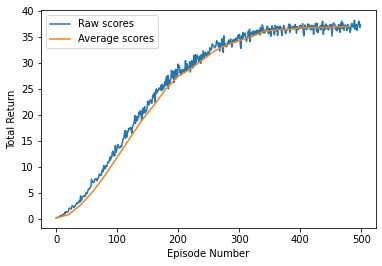

In [7]:
# HYPERPARAMETERS
epsilon = 0.15          # Clip rate for PPO
epsilon_decay = 0.999   # Decay factor for epsilon
beta = 0.01             # Entropy term scaling factor
beta_decay = 0.995      # Decay factor for beta
learning_rate = 2e-4    # Base learning rate for updating model
num_episodes = 500      # Total number of episodes
sgd_epoch = 10          # Number of epochs to 
batch_size = 128        # Mini-batch size 

# Create a policy and optimizer for PPO
policy = PolicyModel().to(device)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

# Initialize the training loop
fig = plt.figure()
scores = []
scores_avg = []
score_window_size = 20 
scores_window = deque(maxlen=score_window_size)
for idx in range(num_episodes):

    # Collect trajectories for each agents
    traj = collect_trajectories(env, policy)
    (log_prob_list, state_list, action_list, reward_list) = traj

    # Update the policy for the number of epochs specified
    for _ in range(sgd_epoch):
        update_ppo_agent(policy, log_prob_list, state_list, action_list, 
            reward_list, epsilon=epsilon, beta=beta, batch_size=batch_size)

    # Once the episode is done, decay epsilon and beta
    epsilon *= epsilon_decay
    beta *= beta_decay

    # Update the average scores
    scores_array = np.array(reward_list)
    score = np.sum(np.mean(scores_array, axis=1))
    scores.append(score)
    scores_window.append(score)
    if idx % score_window_size == 0 or idx == num_episodes-1:
        mean_score = np.mean(scores_window)
        scores_avg.append(mean_score)
        print("\rEpisode {}/{} -- Average Score: {:.3f}".format(idx, num_episodes, mean_score))

# Plot the final scores
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(scores_avg))*score_window_size, scores_avg)
plt.xlabel("Episode Number")
plt.ylabel("Total Return")
plt.legend(["Raw scores", "Average scores"])
plt.show()

# Save the trained agent to file
torch.save(policy.state_dict(),"trained_weights.pth")

### Test the Trained Policy

Now that the final model weights have been saved, we will run a full episode with this policy.

Instead of sampling from the distribution that the policy produces, as was done during training, we will use the mean action.

In [9]:
# Create a new policy model and assign it the trained weights
policy = PolicyModel().to(device)
policy.load_state_dict(torch.load("trained_weights.pth"))

# Run the policy for a full episode
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
done = False
while not done:
    states_tensor = torch.tensor(states, dtype=torch.float, device=device)
    (mean_actions, _, _, _) = policy.forward(states_tensor)
    actions = mean_actions.cpu().detach().numpy()
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        done = True
print('Total score (averaged over agents) with trained policy: {}'.format(np.mean(scores)))

Total score (averaged over agents) with trained policy: 37.83349915435538


In [ ]:
# Finish up by closing the environment
env.close()